# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

# from utils.load_filters_for_primer2 import get_filters_multi_scale
from utils.load_custom_filters_for_primer import get_filters_multi_scale

np.set_printoptions(precision=3, suppress=True)

# declare hyperparameters

In [2]:
PATCH_SIZE = 7  # 28/7=4 which is convenient
PATCH_SIZE = 4
FILTER_THRESHOLD = 0.7
CLUSTER_DISTANCE = 3  # distance within primers that are considered as identical
DECREASE_FACTOR = 0.6  # factor that decrease an end weight after being used
#               [end, c-cl,c-co, Ts,  cross, other]
TYPE_FACTORS1 = [0.7, 1.0, 0.85, 0.95, 0.95, 0.001]  # for primers 0-3   ends
TYPE_FACTORS2 = [0.8, 0.8, 0.7, 0.9, 0.7, 0.001]  # for primers 4-7   Ts
TYPE_FACTORS3 = [0.7, 0.7, 0.7, 0.7, 0.7, 0.001]  # for primers 8-11  corners
TYPE_FACTORS4 = [0.9, 1.0, 1.0, 0.8, 1.0, 0.001]  # for primers 12    cross

# load data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

shape test_image (28, 28)


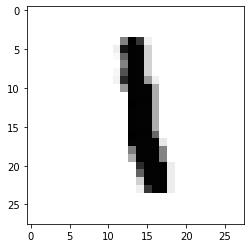

In [4]:
# idx = 0  # label 5
# idx = 1  # label 0
# idx = 2  # label 4
# idx = 3  # label 1
# idx = 4  # label 9
# idx = 5  # label 2
idx = 6  # label 1
# idx = 7  # label 3
# idx = 8  # label 1
# idx = 9  # label 4
# idx = 10  # label 3
# idx = 11  # label 5
# idx = 12  # label 3
# idx = 13  # label 6
# idx = 15  # label 7
# idx = 16  # label 2
# idx = 17  # label 8
# idx = 18  # label 6
# idx = 19  # label 9
# idx = 61
test_image = x_train[idx]
# test_image = x_test[11]
# test_image = x_test[1]
print("shape test_image", np.shape(test_image))
plt.imshow(test_image, cmap='Greys')

# compute bank of primers

In [5]:
def compute_center_of_activity(ft_map, verbose=False):
    # initialize indices (x, y) for each entry
    indices = np.arange(np.shape(ft_map)[0])

    # compute weighted average of the activity, weighted by the indices
    average_x = np.average(ft_map, axis=1, weights=indices)
    average_y = np.average(ft_map, axis=0, weights=indices)

    # compute mean of each pos
    center_x = np.sum(average_x) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=1))
    center_y = np.sum(average_y) * np.sum(indices) / np.sum(np.sum(ft_map + 1e-7, axis=0))

    if verbose:
        print("feat_map")
        print(ft_map)
        print("center ({}, {})".format(center_x, center_y))

    return center_x, center_y

In [6]:
def find_primer(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False, plot_title=""):
    # convert image to tensor
    if len(np.shape(image)) == 2:
        image = np.expand_dims(image, axis=[0, 3])
    else:
        print("image shape is wrong! Expected 2 got ", len(np.shape(image)))
    image = tf.convert_to_tensor(image, dtype='float32')

    # control filters
    if len(np.shape(filters)) == 2:
        filters = np.expand_dims(filters, axis=[2, 3])
    elif len(np.shape(filters)) == 3:  # multi scale
        filters = np.expand_dims(filters, axis=2)
    tf.convert_to_tensor(filters, dtype='float32')

    # apply convolution
    primers = tf.nn.conv2d(image, filters, strides=1, padding='SAME', name="conv1")

    if verbose:
        print("min max patch", np.min(primers), np.max(primers))
        print("shape primers", np.shape(primers))
        max_per_filt = np.amax(primers, axis=(0, 1, 2))
        max_arg_idx = np.flip(np.argsort(max_per_filt)[-5:])
        print("filter idx:", max_arg_idx)
        print("filter value:", max_per_filt[max_arg_idx])

    # filters primers and discard the one under the threshold
    filt_primers = primers.numpy()
    filt_primers = np.amax(filt_primers, axis=(0, -1))
    filt_primers = np.expand_dims(filt_primers, axis=[0, 3])
    filt_primers[filt_primers < threshold] = 0
    if np.max(filt_primers) > 1:
        print("Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity")
        filt_primers[filt_primers > 1] = 1.0

    # split in patches
    patches = tf.image.extract_patches(
        images=filt_primers,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()

    # show each patch
    if do_plot:
        plt.figure()
        plt.title("patch " + plot_title)
        n_patch_x = np.shape(patches)[1]
        n_patch_y = np.shape(patches)[2]
        for i in range(n_patch_x):
            for j in range(n_patch_y):
                patch = np.reshape(patches[0, i, j], [patch_size, patch_size])
                rgb_patch = np.repeat(np.expand_dims(patch, axis=2), 3, axis=2)
                plt.subplot(n_patch_x, n_patch_y, i*np.shape(patches)[2] + j + 1)
                plt.axis('off')
                plt.imshow(rgb_patch)
                # print("min max patch", np.min(patch), np.max(patch))

    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                if verbose:
                    print()
                    print("p:", plot_title)

                coa = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([coa[0] + j*patch_size, coa[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    if do_plot:
        # plot primers
        plt.figure()
        plt.title("primers " + plot_title)
        rgb_image = np.repeat(np.expand_dims(filt_primers[0, ..., 0], axis=2), 3, axis=2)
        for center in centers:
            rgb_image[int(round(center[1])), int(round(center[0]))] = [1.0, 0, 0]
        plt.imshow(rgb_image)

    return centers, max_patch

In [7]:
# compute all primers
def find_primers(image, filters, patch_size=7, threshold=0.5, do_plot=False, verbose=False):
    n_primer = 0
    primers = {}

    for p, filt in enumerate(filters):
        if verbose:
            print("filt p", p)

        primers_pos, max_patch = find_primer(image, filt,
                                             patch_size=patch_size,
                                             threshold=threshold,
                                             do_plot=do_plot,
                                             verbose=verbose,
                                             plot_title=str(p))

        if len(primers_pos) > 0:
            for i in range(len(primers_pos)):
                primers[n_primer] = {"type": p, "pos": primers_pos[i], "max": max_patch[i]}
                n_primer += 1

            if verbose:
                print("primers_pos")
                print(primers_pos)
                print("max patch")
                print(max_patch)
        if verbose:
            print()

    return primers

In [8]:
# define custom filters
top_primers = [[0, 8, 8, 3], [0, 6, 22, 1], [0, 23, 6, 3], [2, 7, 5, 0], [2, 5, 21, 0],  # 0
               [2, 24, 18, 2], [3, 6, 19, 0], [3, 23, 10, 2], [4, 25, 16, 2], [5, 9, 10, 3],
               [5, 18, 23, 1], [6, 5, 13, 0], [6, 23, 16, 2], [7, 7, 10, 3], [7, 21, 6, 3],  # 10
               [7, 15, 9, 3], [9, 8, 13, 0], [9, 16, 7, 2], [9, 16, 19, 1], [9, 23, 11, 2],
               [10, 5, 11, 3], [10, 13, 11, 3], [10, 20, 7, 3], [11, 19, 7, 3], [12, 13, 11, 3],  # 20
               [12, 22, 8, 3], [13, 4, 16, 0], [15, 13, 7, 3], [15, 25, 10, 2], [16, 9, 9, 2],
               [16, 15, 23, 1], [18, 4, 17, 0], [19, 25, 9, 2], [20, 6, 4, 0], [20, 5, 18, 0],  # 30
               [22, 25, 10, 2], [23, 5, 18, 0], [24, 12, 7, 3], [24, 21, 6, 3], [24, 19, 21, 1],
               [25, 7, 7, 3], [26, 8, 9, 0], [27, 7, 7, 3], [27, 13, 11, 3], [29, 11, 9, 3],  # 40
               [30, 14, 11, 3], [30, 17, 13, 0], [32, 18, 14, 2], [35, 15, 10, 2], [36, 3, 16, 0],
               [38, 17, 7, 3], [38, 15, 24, 1], [39, 24, 13, 2], [41, 6, 17, 1], [41, 4, 20, 0],  # 50
               [47, 9, 15, 3], [47, 10, 12, 0], [49, 7, 9, 3], [49, 12, 10, 3], [52, 13, 12, 2],
               [52, 26, 13, 2], [53, 7, 18, 0], [53, 9, 13, 0], [53, 14, 21, 1], [53, 25, 9, 2],  # 60
               [54, 8, 14, 1], [58, 24, 17, 2], [60, 21, 21, 2], [61, 9, 13, 0], [61, 15, 18, 1]]

T_filters = [[0, 8, 12, 0], [2, 14, 18, 1], [4, 15, 15, 1], [9, 14, 11, 3], [13, 20, 13, 2],
             [19, 14, 15, 1], [20, 14, 18, 1], [22, 16, 15, 1], [24, 19, 16, 2], [24, 8, 15, 1],
             [33, 13, 17, 1], [35, 12, 13, 3], [36, 15, 12, 3], [43, 13, 16, 1], [45, 12, 16, 1],
             [48, 12, 15, 1], [50, 12, 14, 2], [54, 13, 17, 1], [57, 14, 16, 1], [60, 15, 22, 1],
             [62, 15, 11, 3], [64, 18, 17, 1]]

corner_filters = [[0, 12, 13, 3], [0, 15, 18, 1], [0, 19, 18, 2], [1, 15, 8, 0], [1, 21, 8, 3], # 0
                  [1, 15, 20, 2], [1, 6, 19, 1], [2, 15, 5, 3], [4, 9, 12, 0], [4, 14, 8, 3],
                  [4, 9, 18, 1], [5, 6, 18, 1], [5, 14, 13, 0], [5, 20, 7, 3], [7, 7, 19, 1],  # 10
                  [7, 15, 18, 1], [7, 21, 14, 2], [10, 7, 16, 1], [10, 14, 17, 1], [10, 21, 14, 2],
                  [11, 12, 12, 0], [11, 15, 11, 3], [11, 16, 14, 1], [11, 19, 12, 2], [12, 7, 16, 1],  # 20
                  [12, 16, 19, 1], [13, 19, 9, 3], [13, 15, 20, 2], [13, 12, 18, 1], [13, 16, 13, 0],
                  [15, 8, 19, 1], [16, 5, 11, 0], [16, 6, 17, 1], [16, 17, 7, 0], [16, 22, 7, 3],  # 30
                  [16, 22, 13, 2], [17, 8, 12, 0], [17, 21, 13, 2], [17, 23, 8, 3], [17, 19, 9, 0],
                  [17, 7, 20, 1], [18, 21, 11, 3], [18, 21, 17, 2], [18, 14, 18, 1], [18, 14, 14, 0],  # 40
                  [19, 8, 18, 1], [19, 8, 12, 0], [19, 14, 11, 3], [20, 15, 8, 3], [21, 12, 9, 0],
                  [21, 20, 8, 3], [21, 17, 20, 2], [21, 6, 19, 1], [22, 7, 15, 0], [22, 16, 10, 3],  # 50
                  [22, 6, 19, 1], [25, 7, 19, 1], [25, 21, 9, 3], [27, 8, 18, 1], [27, 15, 18, 1],
                  [27, 21, 16, 2], [28, 9, 19, 1], [28, 22, 12, 3], [30, 8, 15, 1], [30, 14, 18, 1],  # 60
                  [31, 7, 21, 1], [31, 18, 7, 0], [31, 22, 13, 2], [32, 20, 11, 3], [32, 20, 17, 2],
                  [32, 15, 20, 1], [33, 8, 13, 0], [33, 12, 13, 3], [34, 8, 15, 0], [34, 22, 10, 3],  # 70
                  [34, 7, 19, 1], [35, 8, 15, 0], [35, 13, 16, 1], [35, 19, 13, 2], [36, 19, 13, 3],
                  [36, 20, 18, 2], [36, 16, 18, 1], [37, 13, 10, 0], [37, 21, 9, 3], [37, 18, 18, 2],  # 80
                  [37, 8, 19, 1], [38, 8, 17, 1], [39, 19, 11, 3], [39, 12, 20, 1], [39, 13, 16, 0],
                  [41, 18, 10, 0], [41, 21, 15, 2], [42, 8, 16, 1], [43, 7, 13, 0], [43, 13, 11, 3],  # 90
                  [44, 8, 16, 1], [44, 16, 12, 3], [44, 16, 18, 1], [46, 9, 9, 0], [46, 7, 17, 1],
                  [47, 16, 15, 1], [48, 6, 10, 0], [48, 12, 10, 3], [49, 7, 19, 1], [49, 15, 17, 1], # 100
                  [50, 5, 16, 1], [50, 12, 18, 1], [51, 15, 7, 0], [52, 9, 8, 0], [52, 10, 20, 1],
                  [53, 14, 11, 3], [54, 13, 7, 3], [55, 8, 11, 0], [55, 22, 14, 2], [55, 8, 19, 1],  # 110
                  [57, 8, 19, 1], [57, 9, 10, 0], [57, 15, 9, 3], [51, 7, 20, 1], [56, 9, 20, 1],
                  [61, 15, 9, 3], [62, 21, 16, 2], [63, 18, 20, 2], [63, 11, 10, 0], [63, 10, 21, 1],
                  [64, 18, 7, 3]]

cross_filters = [[5, 15, 17, 0], [9, 17, 15, 0], [16, 16, 17, 0], [17, 14, 13, 0], [26, 14, 16, 0],
                 [31, 14, 14, 0], [38, 16, 16, 0], [39, 20, 14, 0], [41, 13, 14, 0], [46, 15, 13, 0],
                 [53, 14, 15, 0], [55, 15, 14, 0], [61, 16, 14, 0]]

# top_primers = []
# T_filters = []
# corner_filters = []
# cross_filters = []

lmks_pos = [top_primers, T_filters, corner_filters, cross_filters]

filters = get_filters_multi_scale(lmks_pos, filt_size=(9, 9), thresh_val=0.75, neg_factor=6)
print("shape filters", np.shape(filters))

# normalize input and filters
test_image_norm = test_image / 255.
primers_dict = find_primers(test_image_norm, filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=False, verbose=True)
print("primers_dict")
for p in primers_dict:
    print(primers_dict[p])

max filters: 126
shape ends_filters (4, 9, 9, 126)
shape corners_filters (4, 9, 9, 126)
shape T_filters (4, 9, 9, 126)
shape cross_filters (1, 9, 9, 126)
shape filters (13, 9, 9, 126)
filt p 0
min max patch -4.1003313 0.7966593
shape primers (1, 28, 28, 126)
filter idx: [39 34  5 11 40]
filter value: [0.797 0.758 0.754 0.75  0.724]

p: 0
feat_map
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.716 0.    0.   ]]
center (0.99999767021396, 2.99999301064188)

p: 0
feat_map
[[0.    0.797 0.722 0.   ]
 [0.    0.758 0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]
center (1.316979496494606, 0.33308878394320574)
primers_pos
[[12.99999767021396, 2.99999301064188], [13.316979496494605, 4.3330887839432055]]
max patch
[0.7163431, 0.7966593]

filt p 1
min max patch -4.241807 0.6612203
shape primers (1, 28, 28, 126)
filter idx: [59 57 62 52 54]
filter value: [0.661 0.608 0.584 0.577 0.565]

filt p 2
min max patch -3.976193 0.79857534
shap

2022-03-14 10:09:57.559117: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-03-14 10:09:57.580386: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f85f019f1d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-14 10:09:57.580403: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [9]:
def max_pool_primers(primers, dist_threshold=3, sorting='max', verbose=False):
    """
    filter primers with surroundings, i.e. if a primer is within a distance smaller than another one, keep the highest

    :param primers:
    :return:
    """

    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(primers)):
        for p_a in range(p_t + 1, len(primers)):  # only upward diagonal
            # get primers
            p_target = primers[p_t]
            p_agent = primers[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in primers:
        if p not in discarded_primer_idx:
            primer = primers[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [10]:
filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=True)
print("filt_primers", len(filt_primers))
for p in filt_primers:
    print(filt_primers[p])

distance 1.3702634122627926
distance 19.597854459710952
distance 19.748509017439233
distance 21.213210684189498
distance 18.240251169159244
distance 18.38306583499638
distance 19.849080477505524
distance 1.0002860380056178
distance 1.8064997350744
distance 1.4806936194376235
discarded primers
[0, 2, 2, 4]
filt_primers 2
{'type': 0, 'pos': [13.316979496494605, 4.3330887839432055], 'max': 0.7966593}
{'type': 2, 'pos': [16.0, 22.519306380562377], 'max': 0.79857534}


primer (0) type: 0
primer (1) type: 2


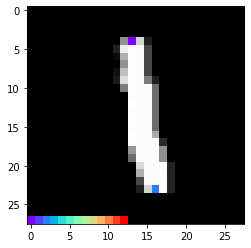

In [11]:
# plot primers on digit
plt.figure()
colors = cm.rainbow(np.linspace(0, 1, np.shape(filters)[0]))
rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

for p in filt_primers:
    primer = filt_primers[p]
    primer_type = primer["type"]
    print("primer ({}) type: {}".format(p, primer_type))
    primer_pos = primer["pos"]
    color = colors[primer_type]
    rgb_im[np.round(primer_pos[1]).astype(int), np.round(primer_pos[0]).astype(int)] = color[:3] * 255

# plot legend
for i in range(np.shape(filters)[0]):
    color = colors[i]
    rgb_im[-1, i] = color[:3] * 255

plt.imshow(rgb_im)

In [12]:
# # save primers positions
# digits = np.arange(65)
# lmk_pos = []
#
# for d in digits:
#     test_image = x_train[d] / 255.
#
#     primers_dict = find_primers(test_image, filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=False, verbose=False)
#     filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=False)
#
#     for l in range(len(filt_primers)):
#         lmk_pos.append([d, filt_primers[l]['pos'][0], filt_primers[l]['pos'][1], filt_primers[l]['type']])
#
# print("length lmk_pos", len(lmk_pos))
# np.save("lmk_pos_train65", lmk_pos)


length lmk_pos 324


# compute Sequence

In [13]:
def compute_type_factor_btw_primers(type1, type2):
    factor = TYPE_FACTORS1[-1]

    def go_down(type, type_factors):
        if type == 2:  # I
            factor = type_factors[0]
        elif type == 9:  # |_
            factor = type_factors[1]
        elif type == 10:  # _|
            factor = type_factors[2]
        elif type == 5:
            factor = type_factors[3]
        elif type == 6:  # _|_
            factor = type_factors[3]
        elif type == 7:  # _|_
            factor = type_factors[3]
        elif type == 12:  # +
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_left(type, type_factors):
        if type == 1:
            factor = type_factors[0]  # -
        elif type == 8:
            factor = type_factors[2]  # -:
        elif type == 9:
            factor = type_factors[1]  # -:|
        elif type == 4:
            factor = type_factors[3]  # -:|
        elif type == 5:
            factor = type_factors[3]
        elif type == 6:
            factor = type_factors[3]
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_up(type, type_factors):
        if type == 0:
            factor = type_factors[0]
        elif type == 11:
            factor = type_factors[1]
        elif type == 8:
            factor = type_factors[2]
        elif type == 4:
            factor = type_factors[3]
        elif type == 5:
            factor = type_factors[3]
        elif type == 7:
            factor = type_factors[3]
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    def go_right(type, type_factors):
        if type == 3:
            factor = type_factors[0]
        elif type == 11:
            factor = type_factors[1]
        elif type == 10:
            factor = type_factors[2]
        elif type == 4:
            factor = type_factors[3]
        elif type == 6:
            factor = type_factors[3]
        elif type == 7:
            factor = type_factors[3]
        elif type == 12:
            factor = type_factors[4]
        else:
            factor = type_factors[-1]
        return factor

    if type1 == 0:
        factor = go_down(type2, TYPE_FACTORS1)
    elif type1 == 1:
        factor = go_right(type2, TYPE_FACTORS1)
    elif type1 == 2:
        factor = go_up(type2, TYPE_FACTORS1)
    elif type1 == 3:
        factor = go_left(type2, TYPE_FACTORS1)

    elif type1 == 4:
        factor = go_down(type2, TYPE_FACTORS2)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_right(type2, TYPE_FACTORS2)
            if factor == TYPE_FACTORS1[-1]:
                factor = go_left(type2, TYPE_FACTORS2)
    elif type1 == 5:
        factor = go_right(type2, TYPE_FACTORS2)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS2)
            if factor == TYPE_FACTORS1[-1]:
                factor = go_down(type2, TYPE_FACTORS2)
    elif type1 == 6:
        factor = go_up(type2, TYPE_FACTORS2)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_right(type2, TYPE_FACTORS2)
            if factor == TYPE_FACTORS1[-1]:
                factor = go_left(type2, TYPE_FACTORS2)
    elif type1 == 7:
        factor = go_left(type2, TYPE_FACTORS2)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS2)
            if factor == TYPE_FACTORS1[-1]:
                factor = go_down(type2, TYPE_FACTORS2)

    elif type1 == 8:
        factor = go_down(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_right(type2, TYPE_FACTORS3)
    elif type1 == 9:
        factor = go_right(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS3)
    elif type1 == 10:
        factor = go_left(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_up(type2, TYPE_FACTORS3)
    elif type1 == 11:
        factor = go_left(type2, TYPE_FACTORS3)
        if factor == TYPE_FACTORS1[-1]:
            factor = go_down(type2, TYPE_FACTORS3)

    elif type1 == 12:
        factor = go_right(type2, TYPE_FACTORS4)

        if factor == TYPE_FACTORS1[-1]:
            factor = go_down(type2, TYPE_FACTORS4)

            if factor == TYPE_FACTORS1[-1]:
                factor = go_left(type2, TYPE_FACTORS4)

                if factor == TYPE_FACTORS1[-1]:
                    factor = go_up(type2, TYPE_FACTORS4)
    else:
        print("Todo type1:", type1)

    return factor

In [14]:
def compute_distance_btw_primers(pos1, pos2, alpha=3):
    return np.log(np.linalg.norm(np.array(pos1) - np.array(pos2)))

In [15]:
def compute_score_matrix(primers, verbose=False):
    # group primers' positions
    score_mat = np.zeros((len(primers), len(primers)))
    for p_t in range(len(primers)):
        # get target primer
        p_target = primers[p_t]

        if verbose:
            print(p_t, ": primer - ", p_target)

        # compute for full matrix since it may not be symmetric due to the different idx_factors
        for p_a in range(len(primers)):
            if p_a != p_t:  # remove self connections
                # get agent primer
                p_agent = primers[p_a]

                type_factor = compute_type_factor_btw_primers(p_target["type"], p_agent["type"])
                dist = compute_distance_btw_primers(p_target["pos"], p_agent["pos"])
                score = type_factor / dist
                score_mat[p_t, p_a] = score


    if verbose:
        print("score_mat")
        print(score_mat)
        print()

    return score_mat

In [16]:
def compute_n_vectors(primers, verbose=False):
    n_vectors = 0
    n_ends = 0
    n_Ts = 0
    n_cross = 0
    n_corners = 0
    for p in range(len(primers)):
        "ends and T adds only half a vector since we need two to make a vector, while the corner adds a full vector as it is between two others"
        "Ts are considered half since the matching factor draws a vector that 'bypass' the T and thus has only one end to it"
        primer = primers[p]
        if primer["type"] in [0, 1, 2, 3]:
            n_vectors += 0.5
            n_ends +=1
        elif primer["type"] in [4, 5, 6, 7]:
            # n_vectors += 1.0
            n_vectors += 1.5
            n_Ts += 1
        elif primer["type"] == 12:  # cross adds two vectors
            n_vectors += 2
            n_cross += 1
        else:
            n_vectors += 1
            n_corners += 1

    # remove a vector if there's only one end, that may mean that the other end has not been found because there's some small corner at the tip
    # but this should not remove the case of a 6 that has one end a T
    if n_ends == 1 and n_Ts == 0:
        n_vectors -= 1

    #remove a vector if there's an odd number of Ts for an even number of ends, that's perhaps a T found within a bar
    elif n_ends%2 == 0 and (n_ends + n_Ts)%2 != 0:
        n_vectors -= 1

    # remove vectors if the number of corners is odd
    # this case can happen with 6
    # if n_ends == 0 and n_Ts == 0 and n_corners%2 != 0:
    #     n_vectors -= 1

    # remove the "double" vector between cross
    if n_cross == 2:
        n_vectors -=1

    n_vectors = np.ceil(n_vectors).astype(int)

    if verbose:
        print("Found {} vectors from {} primers".format(n_vectors, len(primers)))
        print()

    return n_vectors

In [17]:
def build_vector_sequence(score_mat, n_vectors, primers, verbose=False):
    sequence = {}

    agent_idx = 0
    new_chain = True
    # build sequence of primers from the highest matching score
    for v in range(n_vectors):  # one vector less than the number of primers
        # get new chain
        if new_chain and v != 0:
            agent_idx = np.argmax(np.amax(score_mat, axis=1))

        # copy just for verbose purpose
        score_mat_copy = np.copy(score_mat)
        agent_idx_copy = agent_idx

        # get scores for target
        target_idx = np.argmax(score_mat[agent_idx, :])

        # retrieve primers from pair
        p_agent = primers[agent_idx]
        p_target = primers[target_idx]

        # remove connections from selected agent and target
        score_mat[agent_idx, target_idx] = 0.0
        score_mat[target_idx, agent_idx] = 0.0

        # dampen connection for all the primers when used, this ensures that we try first with other primers
        score_mat[agent_idx, :] *= DECREASE_FACTOR
        if new_chain:
            score_mat[:, agent_idx] *= DECREASE_FACTOR

        # set new chain to false
        new_chain = False

        # remove end primers when used, set that we also reach the end of a chain
        if p_target["type"] in [0, 1, 2, 3]:
            new_chain = True
            score_mat[:, target_idx] = 0
            score_mat[target_idx, :] *= .9  # Decrease primer when it reached the end chain
        # remove corner primers when used, we don't want to go back to a corner since it has only two vectors
        elif p_target["type"] in [8, 9, 10, 11]:
            score_mat[:, target_idx] = 0

        # dampen T corners, so we emphasize the end corners more
        elif p_target["type"] in [4, 5, 6, 7]:
            new_chain = True
            score_mat[:, target_idx] *= 0.9

        # add sequence
        sequence[v] = {"type": [p_agent["type"], p_target["type"]], "pos": [p_agent["pos"], p_target["pos"]]}

        # set target as next agent (continuity)
        agent_idx = target_idx

        if verbose:
            print("select from:", score_mat_copy[agent_idx_copy, :])
            print("max value between {}-{}: {}".format(agent_idx_copy, target_idx, score_mat_copy[agent_idx_copy, target_idx]))
            print("sequence:")
            for s in sequence:
                print(sequence[s])
            print("new score matrix")
            print(score_mat)
            if new_chain:
                print("next agent:", "None")
            else:
                print("next agent:", agent_idx)
            print()

    return sequence


In [18]:
def group_primers_to_sequence(primers, verbose=False):
    # get score matrix
    score_mat = compute_score_matrix(primers, verbose=verbose)

    # compute n_vectors
    n_vectors = compute_n_vectors(primers, verbose=verbose)

    # compute sequence
    sequence = build_vector_sequence(score_mat, n_vectors, primers, verbose=verbose)

    return sequence

In [19]:
sequence = group_primers_to_sequence(filt_primers, verbose=True)
print("Final sequence")
for s in sequence:
    print(sequence[s])

0 : primer -  {'type': 0, 'pos': [12.999999167067484, 5.046241586371972], 'max': 0.84713817}
1 : primer -  {'type': 0, 'pos': [21.687377318292274, 5.6829842578151295], 'max': 0.8461253}
2 : primer -  {'type': 2, 'pos': [16.0, 24.50100204398455], 'max': 0.79339564}
3 : primer -  {'type': 7, 'pos': [17.484887257437265, 17.030220900147448], 'max': 0.74999994}
4 : primer -  {'type': 9, 'pos': [6.999993562710642, 17.99999570847376], 'max': 0.7499998}
score_mat
[[0.    0.    0.235 0.373 0.376]
 [0.    0.    0.235 0.381 0.339]
 [0.235 0.235 0.    0.468 0.   ]
 [0.314 0.321 0.394 0.    0.34 ]
 [0.263 0.237 0.    0.297 0.   ]]

Found 4 vectors from 5 primers

select from: [0.    0.    0.235 0.373 0.376]
max value between 0-4: 0.376142188402855
sequence:
{'type': [0, 9], 'pos': [[12.999999167067484, 5.046241586371972], [6.999993562710642, 17.99999570847376]]}
new score matrix
[[0.    0.    0.141 0.224 0.   ]
 [0.    0.    0.235 0.381 0.   ]
 [0.141 0.235 0.    0.468 0.   ]
 [0.188 0.321 0.394 0.

In [20]:
def plot_vectors(image, sequence, fig=None, subplot=None, title=None):

    if fig is None:
        plt.figure()
    else:
        fig.add_subplot(subplot)
        plt.title(title)

    colors = cm.rainbow(np.linspace(0, 1, len(sequence)))
    for s, color in zip(sequence, colors):
        vector = sequence[s]["pos"]

        # add vectors
        vector = np.rint(vector).astype(int)
        # plt.plot([vector[0, 0], vector[1, 0]],[vector[0, 1], vector[1, 1]], color=color, linestyle='solid', marker='o', linewidth=3)
        plt.arrow(vector[0, 0], vector[0, 1], vector[1, 0] - vector[0, 0], vector[1, 1]-vector[0, 1],
                  color=color,
                  linestyle='solid',
                  width=0.5,
                  length_includes_head=True)

    # show image
    plt.imshow(image)

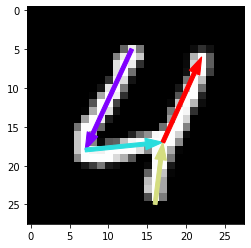

In [21]:
rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)
plot_vectors(rgb_im, sequence)

# VECTORIZE ENTIRE DIGIT

In [22]:
def vectorize_digit(image, filters, do_plot=False, verbose=False):
    # find primers
    primers_dict = find_primers(image, filters, patch_size=PATCH_SIZE, threshold=FILTER_THRESHOLD, do_plot=do_plot, verbose=verbose)

    # clearn primers
    filt_primers = max_pool_primers(primers_dict, dist_threshold=CLUSTER_DISTANCE, verbose=verbose)

    # compute vectors
    sequence = group_primers_to_sequence(filt_primers, verbose=verbose)

    return sequence

In [23]:
# get digits by labels 1
label_oi = 7
idx_train = np.arange(len(y_train))
digits_idx_oi = idx_train[y_train == label_oi]
print("shape digits_idx_oi", np.shape(digits_idx_oi))
print(digits_idx_oi[:50])

train_ones = [3, 24, 70, 105, 248, 366]
train_sevens = [15, 38]

shape digits_idx_oi (6265,)
[ 15  29  38  42  52  71  79  84  91  96 101 103 123 140 141 148 158 168
 185 193 196 212 214 223 230 243 258 263 288 301 305 307 324 337 340 349
 353 370 371 377 384 387 411 422 426 436 446 467 468 478]


shape test_image (28, 28)
{'type': [0, 2], 'pos': [[18.511065184389597, 5.486214842774745], [9.491662697900171, 24.476817207219135]]}


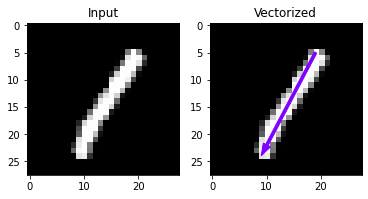

In [24]:
# idx = 0  # label 5
idx = 1  # label 0
# idx = 2  # label 4
# idx = 3  # label 1
# idx = 4  # label 9
# idx = 5  # label 2
# # idx = 6  # label 1
# idx = 7  # label 3
# idx = 8  # label 1
# idx = 9  # label 4
# idx = 10  # label 3
# idx = 11  # label 5
# idx = 12  # label 3
# idx = 13  # label 6
# # idx = 14  # label 1
# idx = 15  # label 7
# idx = 16  # label 2
# idx = 17  # label 8
# idx = 18 # label 8
# idx = 19 # label 9
idx = 20 # label 4
idx = 23
# idx = 42
test_image = x_train[idx] / 255.
# test_image = x_test[1] / 255.
print("shape test_image", np.shape(test_image))

sequence = vectorize_digit(test_image, filters, do_plot=False, verbose=False)

for i in sequence:
    print(sequence[i])

rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

fig = plt.figure()
plt.subplot(121)
plt.title("Input")
plt.imshow(rgb_im)
plot_vectors(rgb_im, sequence, fig, subplot='122', title="Vectorized")

# TEST MULTIPLE DIGITS

/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


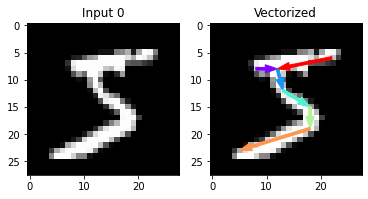

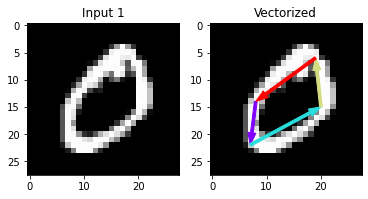

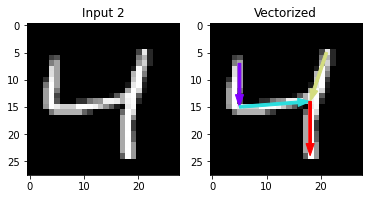

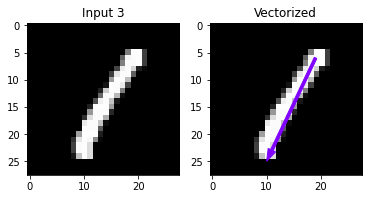

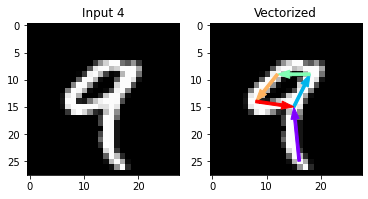

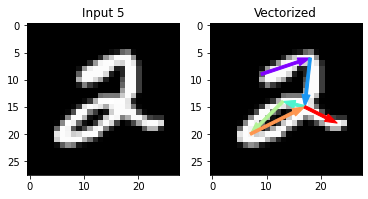

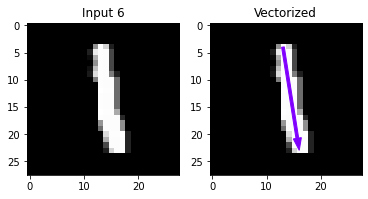

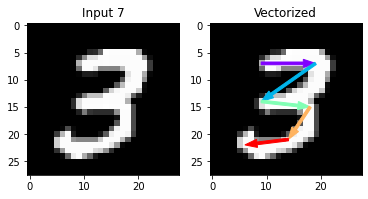

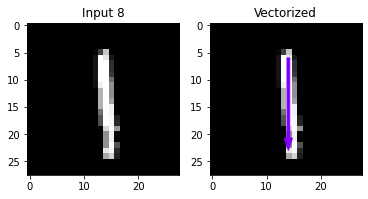

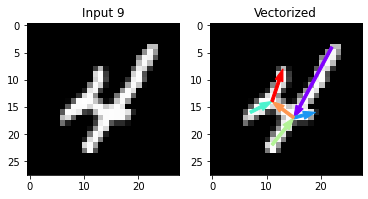

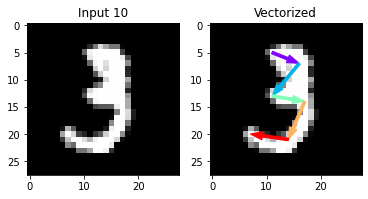

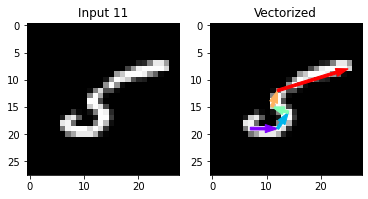

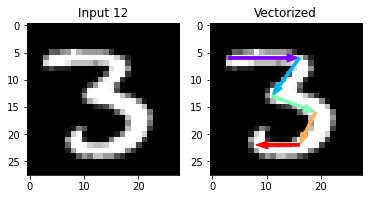

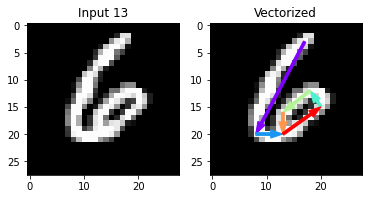

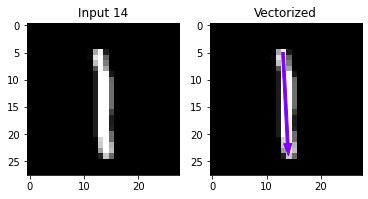

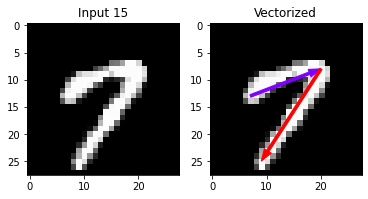

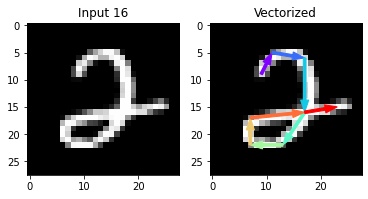

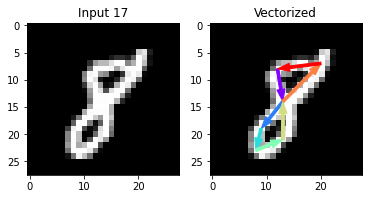

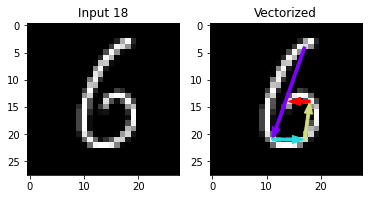

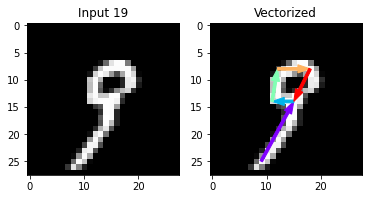

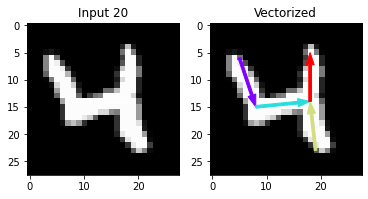

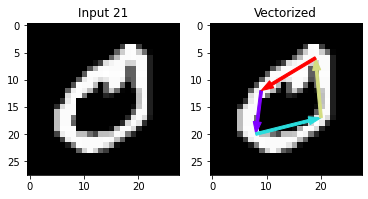

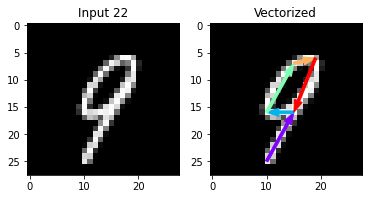

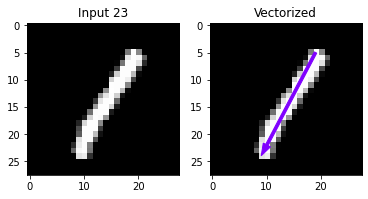

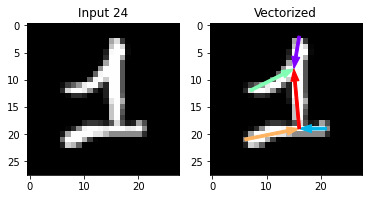

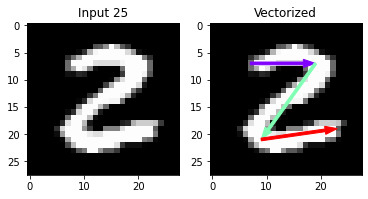

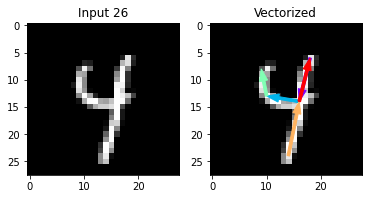

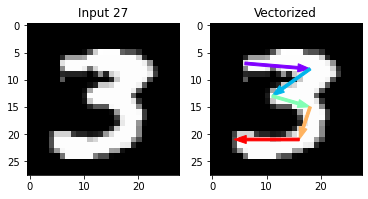

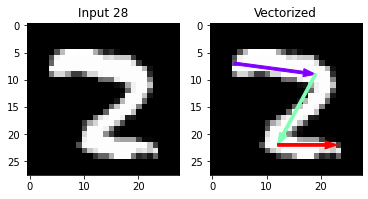

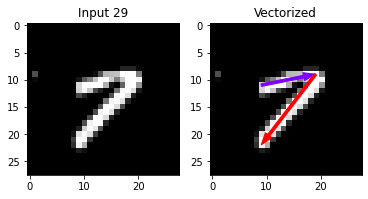

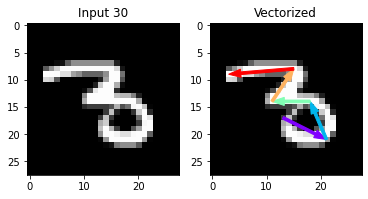

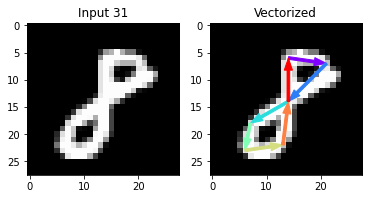

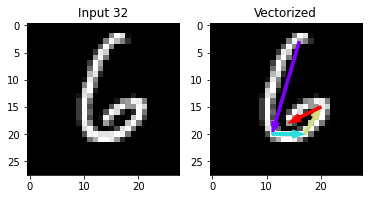

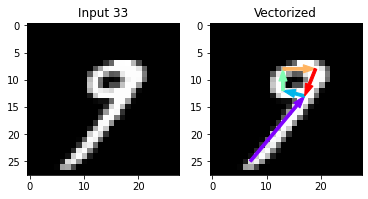

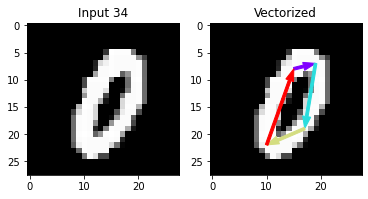

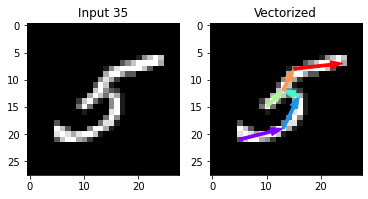

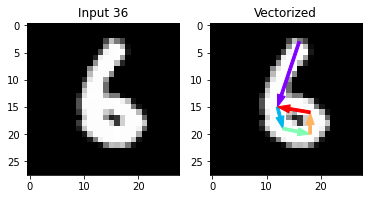

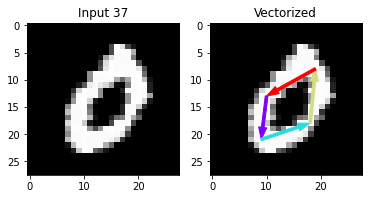

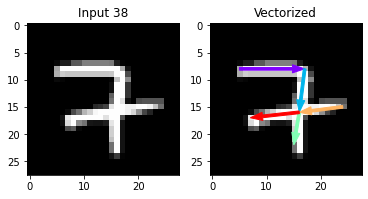

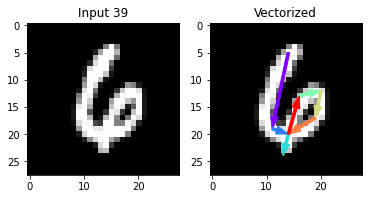

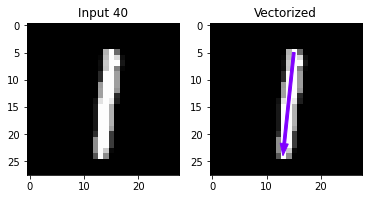

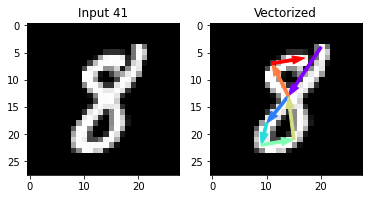

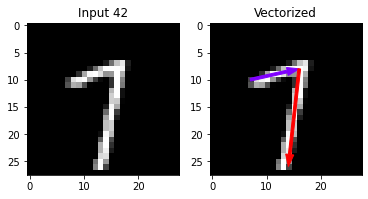

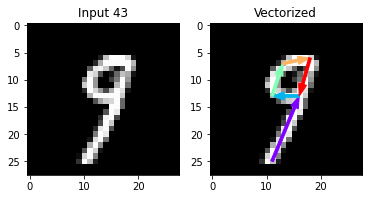

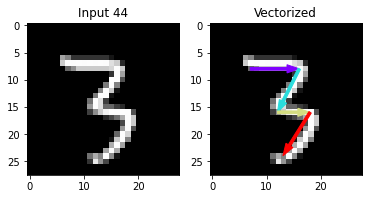

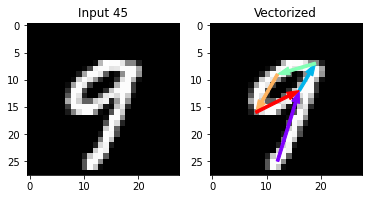

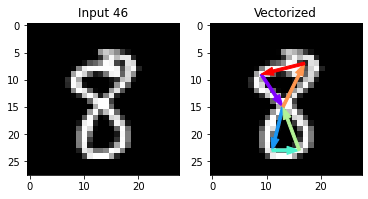

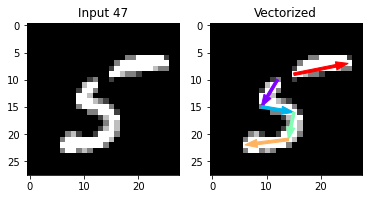

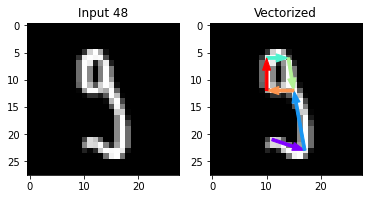

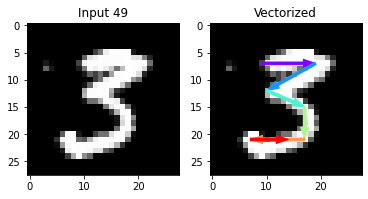

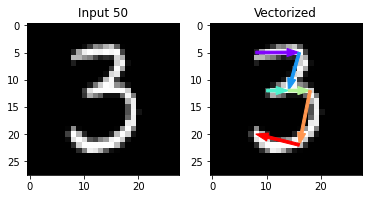

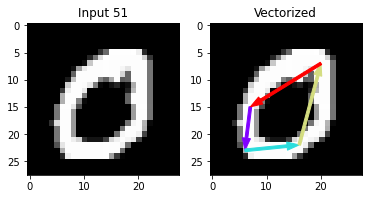

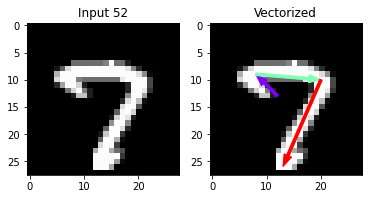

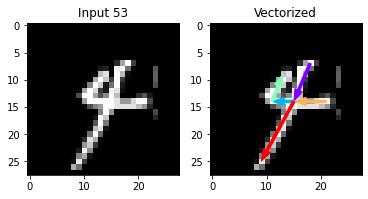

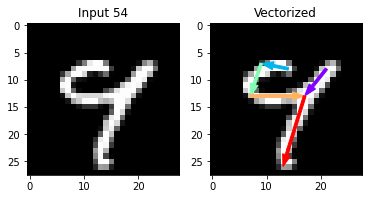

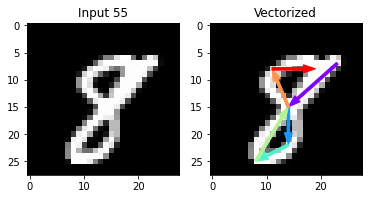

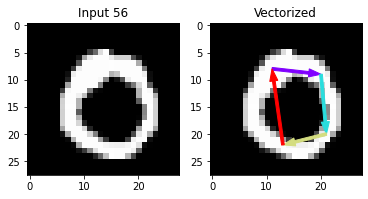

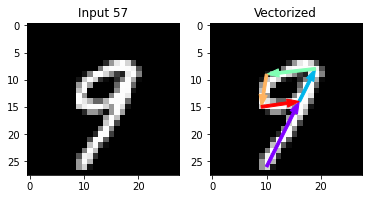

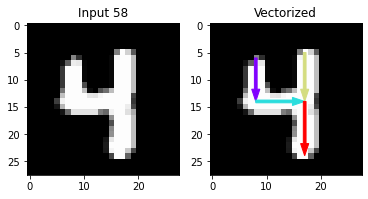

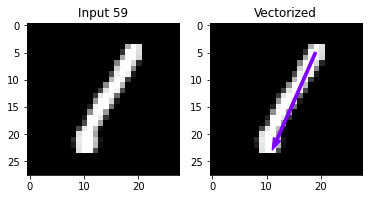

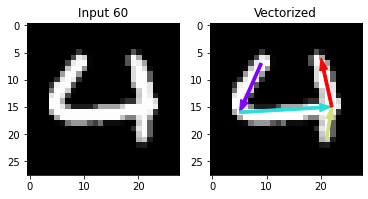

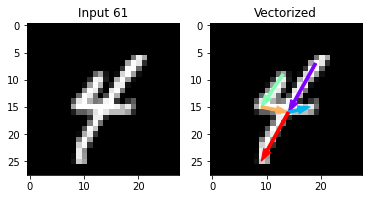

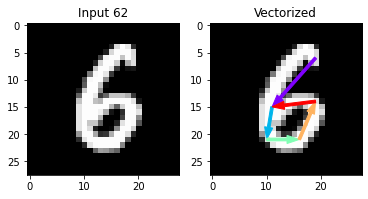

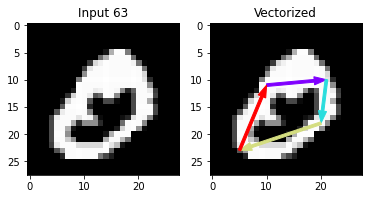

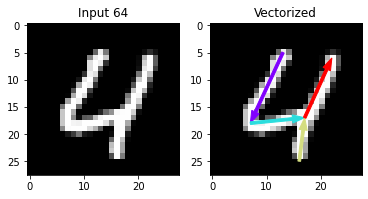

In [25]:
digits = np.arange(65)

for d in digits:
    test_image = x_train[d] / 255.
    # test_image = x_test[d] / 255.

    sequence = vectorize_digit(test_image, filters, do_plot=False, verbose=False)

    rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)

    fig = plt.figure()
    plt.subplot(121)
    plt.title("Input {}".format(d))
    plt.imshow(rgb_im)
    plot_vectors(rgb_im, sequence, fig, subplot='122', title="Vectorized")

# NORM-REFERENCED CLASSIFICATION

In [1132]:
class NormReferenced:
    def __init__(self, n_cat=10):
        self.ref = {}
        self.tun = {}
        self.pred_label_dict = []
        self.cat_counter = np.zeros(n_cat)

    def fit(self, x, y):
        for i in range(len(x)):
            seq = x[i]
            label = y[i]
            num_vector = len(x[i])
            if label not in self.ref:
                self.ref[label] = {'label': label, 'patterns': {}}
                self.tun[label] = {'label': label, 'patterns': {}}

            sequence_types = []
            ref_positions = []
            tun_positions = []
            for v in range(num_vector):
                sequence_types.append(seq[v]['type'])

                # retrieve positions and compute tuning direction
                ref_pos = np.array(seq[v]['pos'][0])
                tun_pos = np.array(seq[v]['pos'][1]) - ref_pos

                ref_positions.append(ref_pos)
                tun_positions.append(tun_pos)

            self.ref[label]['patterns'][int(self.cat_counter[label])] = {'seq': np.array(sequence_types), 'ref_pos': np.array(ref_positions)}
            self.tun[label]['patterns'][int(self.cat_counter[label])] = {'seq': np.array(sequence_types), 'tun_pos': np.array(tun_positions)}
            self.pred_label_dict.append(label)

            # update category_counter
            self.cat_counter[label] += 1

        print()
        for i in self.ref:
            print("reference")
            print(self.ref[i])
            print("tuning")
            print(self.tun[i])
            print()

    def predict(self, x_test, verbose=False):
        pred_lengths = []

        if verbose:
            print("x_test")
            print(x_test)

        # compute projected length on all references
        for i in self.ref:
            n_patterns = len(self.ref[i]['patterns'])
            for p in range(n_patterns):
                # get x reference sequence type
                x_ref_seq = self.ref[i]["patterns"][p]["seq"]

                if verbose:
                    print("x_ref_seq ({})".format(self.ref[i]["label"]))
                    print(x_ref_seq)

                seq_length = 0
                # for each vector of the test match types and compute length
                for v in range(len(x_test)):
                    # declare variable that serve to know if the sequence is found
                    seq_idx = None

                    # get the x_test sequence type
                    x_test_type = x_test[v]['type']

                    # find matching sequence
                    find_idx0 = np.array((x_ref_seq == (x_test_type[0], x_test_type[1])).all(axis=1).nonzero())[0]
                    find_idx1 = np.array((x_ref_seq == (x_test_type[1], x_test_type[0])).all(axis=1).nonzero())[0]  # match in other direction as well

                    # retrieve index from tbe matching sequence
                    if len(find_idx0) > 0:
                        seq_idx = find_idx0[0]
                    elif len(find_idx1) > 0:
                        seq_idx = find_idx1[0]
                    else:
                        if verbose:
                            print("sequence type {} not found in ref seq!".format(x_test_type))

                    # compute projections
                    if seq_idx is not None:
                        # transform vect to simple 2d vector from ref (0, 0)
                        vect = np.array(x_test[v]['pos'][1]) - np.array(x_test[v]['pos'][0])
                        tun_vect = self.tun[i]['patterns'][p]['tun_pos'][seq_idx]
                        v = np.abs(np.dot(vect, tun_vect / np.linalg.norm(tun_vect)))  # v-shape encoding

                        if verbose:
                            print("vect: {} ({}): ".format(vect, np.linalg.norm(vect)))
                            print("tun_vect:", tun_vect)
                            print("length v {} for seq {}".format(v, x_test_type))

                        seq_length += v

                pred_lengths.append(seq_length)

        max_length_idx = np.argmax(pred_lengths)
        pred_label = self.pred_label_dict[max_length_idx]

        if verbose:
            print("pred_lengths")
            print(pred_lengths)
            print("max_length_idx {}, label: {}".format(max_length_idx, pred_label))
            print()

        return pred_label

In [1634]:
# TRAIN MODEL
train_digits = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]
# train_digits = [1, 3, 24, 5, 25, 7, 30, 2, 9, 0, 11, 18, 13, 15, 38, 17, 41, 4, 48]  # 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9
# train_digits = [1]
# train_digits = [3, 24]
labels = []
x_ = []
for d in train_digits:
    seq = vectorize_digit(x_train[d] / 255., filters, do_plot=False, verbose=False)
    x_.append(seq)
    labels.append(y_train[d])
# define norm-refere nce object
NR = NormReferenced()

# train reference and tuning vectors
NR.fit(x_, labels)


reference
{'label': 0, 'patterns': {0: {'seq': array([[ 8,  9],
       [ 9, 10],
       [10, 11],
       [11,  8]]), 'ref_pos': array([[ 8.   , 14.022],
       [ 7.   , 22.   ],
       [20.   , 15.   ],
       [19.   ,  6.   ]])}}}
tuning
{'label': 0, 'patterns': {0: {'seq': array([[ 8,  9],
       [ 9, 10],
       [10, 11],
       [11,  8]]), 'tun_pos': array([[ -1.   ,   7.978],
       [ 13.   ,  -7.   ],
       [ -1.   ,  -9.   ],
       [-11.   ,   8.022]])}}}

reference
{'label': 1, 'patterns': {0: {'seq': array([[0, 2]]), 'ref_pos': array([[18.505,  5.506]])}, 1: {'seq': array([[0, 7],
       [3, 6],
       [1, 7],
       [1, 6],
       [6, 7]]), 'ref_pos': array([[16.234,  2.279],
       [21.   , 19.   ],
       [ 6.514, 12.   ],
       [ 6.031, 20.651],
       [16.   , 19.   ]])}}}
tuning
{'label': 1, 'patterns': {0: {'seq': array([[0, 2]]), 'tun_pos': array([[-8.741, 19.218]])}, 1: {'seq': array([[0, 7],
       [3, 6],
       [1, 7],
       [1, 6],
       [6, 7]]), 'tun_pos':

In [1635]:
# TEST MODEL
# predict data
preds = []
preds_seq = []
test_seq = []
for i in range(10000):
    test_image = x_test[i] / 255.
    seq = vectorize_digit(test_image, filters, do_plot=False, verbose=False)

    # fig = plt.figure()
    # plt.title("Input {}".format(y_test[i]))
    # rgb_im = np.repeat(np.expand_dims(test_image, axis=2), 3, axis=2)
    # plt.imshow(rgb_im)

    pred = NR.predict(seq, verbose=False)

    preds.append(pred)

    # keep only the ones that have a sequence (at least one vector)
    if len(seq) > 0:
        preds_seq.append(pred)
        test_seq.append(y_test[i])

print("preds", np.shape(preds))
print("preds_seq", np.shape(preds_seq))
if len(preds) < 10:
    print(preds)

Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity
Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity
Max of nb_primers is greater than 1! This could mean that the the filter is not normalized, imaged clamped to 1 to avoid issues with the center of activity
preds (10000,)
preds_seq (8918,)


In [1636]:
# test prediction accuracy
n_correct = 0
for i, pred in enumerate(preds):
    if pred == y_test[i]:
        n_correct += 1

n_correct_seq = 0
for i, pred in enumerate(preds_seq):
    if pred == test_seq[i]:
        n_correct_seq += 1

accuracy = n_correct / len(preds)
accuracy_seq = n_correct_seq / len(preds_seq)
print("accuracy: {} (n_correct: {}, n_total: {})".format(accuracy, n_correct, len(preds)))
print("accuracy_seq: {} (n_correct_seq: {}, n_total: {})".format(accuracy_seq, n_correct_seq, len(preds_seq)))

# 30 digits
# thresh = 0.75, neg_val = -10
# accuracy: 24.22%, accuracy_seq: 30.89%, n_preds_seq: 6966

# thresh = 0.75, neg_val = -8
# accuracy: 26.61%, accuracy_seq: 32.11%, n_preds_seq: 7732

# thresh = 0.75, neg_val = -7
# accuracy: 28.23%, accuracy_seq: 32.96%, n_preds_seq 8158:

# thresh = 0.75, neg_val = -6
# accuracy: 29.89%, accuracy_seq: 33.84%, n_preds_seq 8545:

# 50 digits - 1 training example
# thresh = 0.75, neg_val = -6
# accuracy: 31.15%, accuracy_seq: 34.49%, n_preds_seq 8837:

# 50 digits - 2 training examples
# thresh = 0.75, neg_val = -6
# accuracy: 31.91 %, accuracy_seq: 35.25%, n_preds_seq : 8837

# 60 digits - 1 training example
# thresh = 0.75, neg_val = -6
# accuracy: 31.72%, accuracy_seq: 34.56%, n_preds_seq 8942:

accuracy: 0.3316 (n_correct: 3316, n_total: 10000)
accuracy_seq: 0.3630858936981386 (n_correct_seq: 3238, n_total: 8918)


# BUILD CUSTOM PRIMERS

In [62]:
def build_primer(lmk_pos, thresh_val=0.75, filt_size=(7, 7), neg_factor=6):
    """

    :param lmk_pos: nx4 matrix, with 4 the following parameters: 0: idx of the mnsit img, 1: posX, 2: posX, 3: n_rotate
    :param thresh_val:
    :param filt_size:
    :param neg_factor: value to which the negative parts of the filters get multiplied
    :return:
    """
    pad_x = int(filt_size[0] / 2)
    pad_y = int(filt_size[1] / 2)

    # define start and stop
    start_x = lmk_pos[1]-pad_x
    end_x = lmk_pos[1]+pad_x+1
    start_y = lmk_pos[2]-pad_y
    end_y = lmk_pos[2]+pad_y+1

    # define filter for primer
    img = x_train[lmk_pos[0]] / 255.
    patch = img[np.maximum(start_x, 0):end_x, np.maximum(start_y, 0):end_y]
    print("[{}:{}, {}:{}]".format(start_x, end_x, start_y, end_y))
    print("shape patch", np.shape(patch))

    # add zeros if patch is smaller than the dimension
    if start_x < 0:
        zeros_patch = np.zeros((filt_size[0] - np.shape(patch)[0], np.shape(patch)[1]))
        patch = np.vstack([zeros_patch, patch])
    elif end_x > np.shape(img)[0]:
        zeros_patch = np.zeros((end_x - np.shape(img)[0], np.shape(patch)[1]))
        patch = np.vstack([patch, zeros_patch])
    if start_y < 0:
        zeros_patch = np.zeros((np.shape(patch)[0], filt_size[1] - np.shape(patch)[1]))
        patch = np.hstack([zeros_patch, patch])
    elif end_y > np.shape(img)[1]:
        zeros_patch = np.zeros((np.shape(patch)[0], end_y - np.shape(img)[1]))
        patch = np.hstack([patch, zeros_patch])

    # create filter
    filter = np.copy(patch)

    # control size
    if np.shape(filter)[0] != filt_size[0]:
        print("Dimension 0 of patch is not matching ,expected {}, received {}".format(filt_size[0], np.shape(patch)[0]))
    if np.shape(filter)[1] != filt_size[1]:
        print("Dimension 1 of patch is not matching ,expected {}, received {}".format(filt_size[1], np.shape(patch)[1]))

    # compute the number of zeros within the patch
    n_zeros = np.count_nonzero(patch == 0)

    # compute alpha factor to reach the thresh_value
    max_matching_val = np.sum(filter * patch)
    alpha = thresh_val / max_matching_val

    # normalize filter
    filter *= alpha

    # set filter to neutral with the zeros
    offset_neg_val = - neg_factor * np.sum(filter) / n_zeros
    filter[filter == 0] = offset_neg_val

    # apply number of rotation
    filter = np.rot90(filter, lmk_pos[3])

    return filter

[21:30, 23:32]
shape patch (7, 5)
shape patch (9, 5)
shape zero patch (9, 4)
shape patch (9, 9)
min max primer nan nan


/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
/Users/michaelstettler/PycharmProjects/BVS/BVS/venv/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


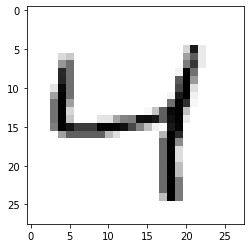

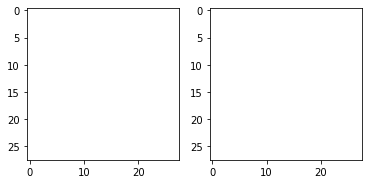

In [63]:
idx = 2
n_rotate = 0
#[0, 12, 13, 3], [0, 15, 18, 1], [0, 19, 18, 2], [1, 15, 8, 0], [1, 21, 8, 3], [1, 15, 20, 2], [1, 6, 19, 1], [2, 15, 5, 3], [4, 9, 12, 0], [4, 14, 8, 3], [4, 9, 18, 1], [5, 6, 18, 1], [5, 14, 13, 0], [5, 20, 7, 3], [7, 16, 18, 1]
# filter = build_primer([idx, 16, 18, n_rotate])
top_primers = [[0, 8, 8, 3], [0, 6, 22, 1], [0, 23, 6, 3], [2, 7, 5, 0], [2, 5, 21, 0], [2, 23, 18, 2], [3, 7, 19, 0], [3, 22, 10, 2], [4, 23, 16, 2], [5, 10, 10, 3], [5, 18, 23, 1], [6, 5, 13, 0], [6, 23, 16, 2], [7, 7, 10, 3], [7, 21, 6, 3], [7, 15, 9, 3], [9, 8, 13, 0], [9, 16, 7, 2], [9, 16, 19, 1], [9, 23, 11, 2], [10, 5, 10, 3], [10, 13, 10, 3], [10, 20, 7, 3]]

filter = build_primer([2, 25, 27, 0], filt_size=(9, 9), neg_factor=10)
filter = np.rot90(filter, n_rotate)

# plot image
test_image = x_train[idx] / 255.
fig = plt.figure()
plt.imshow(test_image, cmap='Greys')

# transform to fit tf
test_image = np.expand_dims(test_image, axis=[0, 3])
test_image = tf.convert_to_tensor(test_image, dtype='float32')

filter = np.expand_dims(filter, axis=[2, 3])
filter = tf.convert_to_tensor(filter, dtype='float32')

# apply convolution
primer = tf.nn.conv2d(test_image, filter, strides=1, padding='SAME', name="conv1")
primer = primer.numpy()[0, ..., 0]
print("min max primer", np.amin(primer), np.amax(primer))

# plot
plt.figure()
# plot convolution
plt.subplot(121)
plt.imshow(primer, cmap='Greys')

# plot thresholded
plt.subplot(122)
max_primer = np.copy(primer)
max_primer[max_primer < 0.7] = 0
plt.imshow(max_primer, cmap='Greys')